# Import Required Libraries

Import necessary libraries such as geopandas, numpy, and matplotlib.


In [30]:
# Import Required Libraries
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import mapping
from rasterio.features import rasterize

In [31]:
road = np.array(Image.open("./road_img.png", "r"))

# Load GeoJSON File

Load a GeoJSON file into a GeoDataFrame using geopandas.read_file().


In [32]:
# Load GeoJSON File
GEOJSON_PATH = "/media/noan/USB1/Poznan_Internship/Data/block3_surfaces.geojson"
gdf = gpd.read_file(GEOJSON_PATH)
gdf.head()

,id,geom,object_id,type,type_id,material,color,baf,a [m2],user,subzone,measurement_date,species,species_latin,height_m,habitat,geometry
0,325,0106000020810800000100000001030000000100000008...,283891,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,133.29,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428712.853 5808195.102, 64287..."
1,326,010600002081080000010000000103000000010000000C...,283890,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,170.24,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428731.783 5808217.15, 642872..."
2,327,0106000020810800000100000001030000000100000054...,283902,Droga utwardzona,2,NULL,NULL,0.0,1145.68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428816.419 5808210.043, 64288..."
3,328,0106000020810800000100000001030000000100000009...,283892,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,272.14,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428752.15 5808234.326, 642875..."
4,329,0106000020810800000100000001030000000100000025...,283905,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,1094.4,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((6428762.068 5808269.82, 642876..."


# Convert GeoDataFrame to Desired CRS

Convert the GeoDataFrame to a specific coordinate reference system (CRS) using the to_crs() method.


In [33]:
# Convert GeoDataFrame to Desired CRS
TARGET_CRS = "EPSG:3857"  # Web Mercator projection
gdf = gdf.to_crs(TARGET_CRS)
gdf.head()

,id,geom,object_id,type,type_id,material,color,baf,a [m2],user,subzone,measurement_date,species,species_latin,height_m,habitat,geometry
0,325,0106000020810800000100000001030000000100000008...,283891,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,133.29,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1887143.084 6873225.486, 18871..."
1,326,010600002081080000010000000103000000010000000C...,283890,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,170.24,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1887173.521 6873262.084, 18871..."
2,327,0106000020810800000100000001030000000100000054...,283902,Droga utwardzona,2,NULL,NULL,0.0,1145.68,NULL,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1887312.108 6873252.441, 18873..."
3,328,0106000020810800000100000001030000000100000009...,283892,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,272.14,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1887206.424 6873290.729, 18872..."
4,329,0106000020810800000100000001030000000100000025...,283905,Droga utwardzona,2,concrete_cobblestone,NULL,0.3,1094.4,roadway,NULL,NULL,NULL,NULL,NULL,NULL,"MULTIPOLYGON (((1887221.803 6873349.16, 188722..."


# Extract Geometry Bounds

Extract the minimum and maximum bounds of the geometries in the GeoDataFrame to define the mask dimensions.


In [34]:
# Extract Geometry Bounds
min_x, min_y, max_x, max_y = gdf.total_bounds
print(f"Bounds: Min ({min_x}, {min_y}), Max ({max_x}, {max_y})")

Bounds: Min (1886930.722778037, 6873013.859118296), Max (1887403.1974838187, 6873475.558561517)


# Generate Mask from GeoDataFrame

Create a binary mask by rasterizing the GeoDataFrame geometries onto a numpy array.


In [35]:
# Generate Mask from GeoDataFrame
# resolution = 1  # Define resolution of the mask
# width = int((max_x - min_x) / resolution)
# height = int((max_y - min_y) / resolution)

[height, width, _] = road.shape

# Create an affine transformation for the raster
transform = rasterio.transform.from_bounds(min_x, min_y, max_x, max_y, width, height)

# Rasterize the geometries
shapes = ((geom, 1) for geom in gdf.geometry)
mask = rasterize(shapes, out_shape=(height, width), transform=transform, fill=0, dtype=np.uint8)

print(f"Generated mask with dimensions: {mask.shape}")

Generated mask with dimensions: (1096, 1565)


# Visualize Mask and GeoDataFrame

Use matplotlib to overlay the GeoDataFrame on top of the generated mask for visualization.


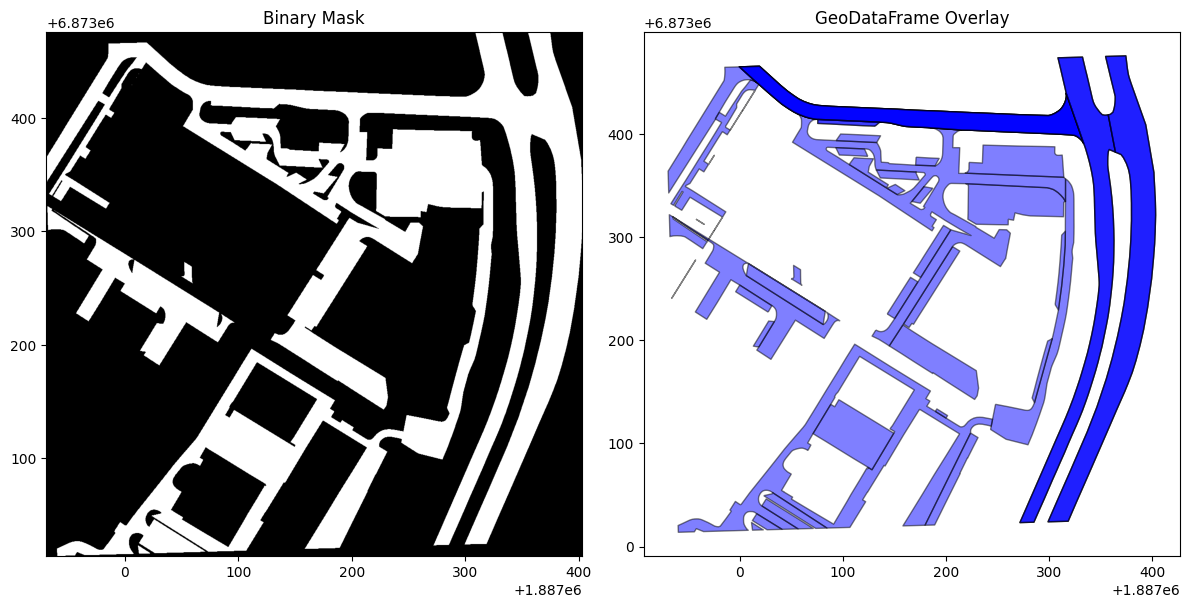

In [36]:
# Visualize Mask and GeoDataFrame
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the binary mask
ax[0].imshow(mask, cmap="gray", extent=(min_x, max_x, min_y, max_y))
ax[0].set_title("Binary Mask")

# Plot the GeoDataFrame
gdf.plot(ax=ax[1], color="blue", alpha=0.5, edgecolor="black")
ax[1].set_title("GeoDataFrame Overlay")

plt.tight_layout()
plt.show()

In [37]:
# Save the binary mask to an image file
from PIL import Image

# Convert the mask to an image (scale to 255 for better visualization)
mask_image = Image.fromarray(mask * 255)
mask_image.save("road_mask_binary.png")

print("Binary mask saved as 'binary_mask.png'")

Binary mask saved as 'binary_mask.png'


In [46]:
from image_similarity_measures.evaluate import evaluation

metrics = ["rmse", "psnr", "ssim", "fsim"]

print(
    "No filters:", 
    evaluation(org_img_path="./road_mask_step_0.png", pred_img_path="./road_mask.png", metrics=metrics)
)

print(
    "Area closing:", 
    evaluation(org_img_path="./road_mask_step_1.png", pred_img_path="./road_mask.png", metrics=metrics)
)

print(
    "Area closing + Gaussian filter:", 
    evaluation(org_img_path="./road_mask_step_2.png", pred_img_path="./road_mask.png", metrics=metrics)
)

print(
    "Area closing + Gaussian filter + Threshold:", 
    evaluation(org_img_path="./road_mask_binary.png", pred_img_path="./road_mask.png", metrics=metrics)
)

No filters: {'rmse': 0.027524860575795174, 'psnr': 31.20353589851201, 'ssim': 0.7516702110078018, 'fsim': 0.4258802977445881}
Area closing: {'rmse': 0.024720171466469765, 'psnr': 32.137046585272024, 'ssim': 0.7921773041116938, 'fsim': 0.4424813085055723}
Area closing + Gaussian filter: {'rmse': 0.018307330086827278, 'psnr': 34.750178899081675, 'ssim': 0.7656705051360374, 'fsim': 0.3400000140704662}
Area closing + Gaussian filter + Threshold: {'rmse': 0.03914466127753258, 'psnr': 28.14450690258856, 'ssim': 0.5804984592096164, 'fsim': 0.4434442784437062}
